In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys,os
sys.path.insert(1, '../src/')
import integrate_odes as io
from astropy import constants

This notebook serves as a tutorial for setting up and running a single simulation. The physical system consists of three bodies, with masses `m1`, `m2`, and `m3`. We adopt Jacobi coordinates to describe this three-body system, so that the orbit of `m1` and `m2` is referenced as the inner orbit, and the orbit of `m3` relative to the center of mass of `m1` and `m2` is referenced as the outer orbit. The code calculates the orbital and spin evolution of the triple system, accounting for the following physical effects:

-Gravitational torques between the inner and outer orbits, to octupole-order in the semi-major axis ratio (`a1`/`a2`).

-Apsidal precession of the inner orbit (`m1` and `m2`), due to general relativity, tides, and oblateness.

-Spin-orbit coupling of the inner orbit.

-Tidal dissipation in `m1` and `m2`.

-Spin-down of `m1` and `m2` due to magnetized winds (magnetic braking). 

Most of these effects are included by default, but can be toggled on and off by the user as desired. See the definition of the function `integrate_triple` in `src/integrate_odes.py` to determine which effects are included by default.

Here we demonstrate an application of the code, which is to model planet migration and hot Jupiter formation in stellar binary systems, as explored in [Anderson, Lai, & Storch 2016](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.3671A/abstract). 

Let's set up a triple system consisting of a Jovian-type planet in a wide, equal-mass binary star system. We'll place the planet (mass `m2`) on a nearly circular orbit around one of the stars (mass `m1`), with a semi-major axis of 1 AU. The semi-major axis of the binary stars orbit will be 100 AU. The distant star (mass `m3`) will introduce perturbations on the planet's orbit around its host star.

In [2]:
# Masses and radii in units of solar masses and AU
m1, R1 = 1.0, constants.R_sun.to_value("au")
m2, R2 = 5*constants.M_jup.to_value("M_sun"), constants.R_jup.to_value("au")
m3 = 1.0

# Semi-major axes of the inner and outer orbits in AU
a1 = 1.
a2 = 100.0

# Initial eccentricities of the inner and outer orbits
e1 = 0.01
e2 = 0.01

We also need to specify the three angles for each orbit: argument of pericenter (`peri1`, `peri2`), longitude of ascending node (`node1`, `node2`), and inclination (`I1`, `I2`). Let's specifiy the mutual inclination between the inner and outer orbits (`Imut`) to be 83 degrees (this large inclination will cause dynamical perturbations that cause the orbit of the planet to shrink over long timescales). We can then use the `set_inclination` function from `integrate_odes.py` to calculate the individual inclinations to feed to the ODE solver, assuming the total angular momentum vector of the triple system is along the z-axis.

In [3]:
# Initial angles in radians
Imut = 83.*np.pi/180.
I1, I2 = io.set_inclinations(m1, m2, m3, a1, e1, a2, e2, Imut)
peri1, node1 = 0.,0.
peri2 = 0.
node2 = node1 - np.pi

We also need to specify the rotation periods of `m1` and `m2`, along with constants describing the internal structure of each body, tidal dissipation parameters, and magnetic braking parameters. Precise definitions of these variables can be found in Anderson, Lai, & Storch 2016.

In [4]:
# Spin periods of the primary and secondary of the inner binary in years
Pstar1 = 10.0 / 365.25
Pstar2 = 10.0 / (24 * 365.25)

# Internal structure constants
k21, k22 = 1.5 * 0.05, 0.37 / 2
ks1, ks2 = 0.1, 0.25

# Tidal lag time (years)
tlag1 = 0.0
tlag2 = 1.0 / (3.15e7)

# Magnetic braking coefficients
alpha1 = 1.5e-14
alpha2 = 0.0

# Simulation number (not important for running just a single simulation, so we'll set it to 0 here
simnum = 0

Now that our parameters and initial conditions have been defined, we store them in a dictionary called `parameters`, and call the `set_triple_properties` function to update this dictionary with additional calculated quanities that will be needed by the ODE solver.

In [5]:
# Create a dictionary to store the initial conditions and triple properties
parameters = {
    "simnum": simnum,
    "m1": m1,
    "m2": m2,
    "m3": m3,
    "R1": R1,
    "R2": R2,
    "a1": a1,
    "a2": a2,
    "e1": e1,
    "e2": e2,
    "k21": k21,
    "k22": k22,
    "ks1": ks1,
    "ks2": ks2,
    "tlag1": tlag1,
    "tlag2": tlag2,
    "alpha1": alpha1,
    "alpha2": alpha2,
    "Pstar1": Pstar1,
    "Pstar2": Pstar2,
    "I1": I1,
    "node1": node1,
    "peri1": peri1,
    "I2": I2,
    "node2": node2,
    "peri2": peri2,
    "Imom1": ks1 * m1 * R1 * R1,
    "Imom2": ks2 * m2 * R2 * R2,
}
    
# Update the parameter dictionary with additional calculated quantities
parameters = io.set_triple_properties(parameters)

We also need to specify stopping conditions for the ODE solver. We want to integrate the system of ODEs until some amount of time (`tend`) has elapsed, or one of various possible events has occurred. The parameters `min_a` and `min_e` tell the ODE solver to keep integrating the ODEs up to time `tend`, unless the semi-major axis and eccentricity of the planet (the inner orbit) both become smaller than these values, indicating that a hot Jupiter has formed. The parameter `min_peri` causes the ODE solver to stop the integration if the eccentricity of the planet gets so high that it will be destroyed by tidal forces. 

In [6]:
# Integration timespan (years).
# Can set tend = x * parameters["tk"] to integrate for x secular timescales
tend = 1e7

# Stopping conditions
min_peri = parameters["Rtide"]
min_a, min_e = 0.1, 0.5

# Specify density of the ODE solution output
Npoints = 10000

# Define an array of times at which to record the ODE solution
t = np.linspace(0, tend, Npoints)

Now it's time to integrate the system of ODEs, using the `integrate_triple` function. We set the flag `evolve_spin2_axis` to False, so that the spin axis of the planet will be aligned with the orbit, as broadly expected from planet formation theory. We set the flag `mbraking1` to True to model the spin-down of the planet-hosting star due to magnetic braking (which has an important implications for the spin-orbit dynamics and obliquity). Finally, we set the flag `diss_tide2` to True to model tidal dissipation in the planet. This will cause the orbit of the planet to shrink over long timescales, so that the planet gradually moves closer to its star. We could have also set the flag `diss_tide1` to True to model tidal dissipation in the host star, but the stellar tides are much weaker compared to the planetary tides, so we neglect them in this application.

After the integrator finishes, the code prints the outcome of the simulation, and returns the times at which the ODE solution was evaluated (`t`), the ODE solution as an array (`sol`), and the simulation outcome as an integer (`flag`) as well as a string (`sflag`). The code also returns a quality flag (`qflag`), indicating whether the numerical integration was successful. These flags are useful when conducting many simulations and saving the outcomes of each simulation in a file. The outcome `NM` (`0`) here means that the planet did not undergo any significant migration (changes in its semi-major axis).

After the ODEs have been numerically integrated, we pass the ODE solution to the `process_output` function to store everything in a dataframe and calculate various quantities of interest.

In [7]:
# Integrate the ODEs
t, sol, flag, sflag, qflag = io.integrate_triple(
    parameters,
    t,
    evolve_spin2_axis=False,
    diss_tide2=True,
    mbraking1=True,
    min_peri=min_peri,
    min_a=min_a,
    min_e=min_e,
)

# Process the output of the ODEs
df = io.process_output(t, sol, parameters, evolve_spin2_axis=False)

Setting up simulation # 0
GR apsidal precession:  True
Tidal apsidal precession due to primary:  True
Tidal apsidal precession due to secondary:  True
Spin apsidal precession due to primary:  True
Spin apsidal precession due to secondary:  True
Spin nodal precession due to primary:  True
Spin nodal precession due to secondary:  True
Evolve spin axis of secondary:  False
Tidal dissipation in primary:  False
Tidal dissipation in secondary:  True
Magnetic braking in primary:  True
Magnetic braking in secondary:  False
Octupole:  True
Minimum pericenter:  0.007663600582638584
Minimum a and e:  0.1 0.5
Exited the first integration loop. t/tmax, a, e, peri, eps_gr =  1.0 1.0 0.49 0.52 0.0
Finished the integration. Quality flag:  True
Outcome:  NM 0




Now we can plot the results, first setting some plot aesthetics:

In [8]:
from matplotlib import rc, rcParams
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

plt.rcParams["ytick.right"] = True
plt.rcParams["xtick.top"] = True
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"

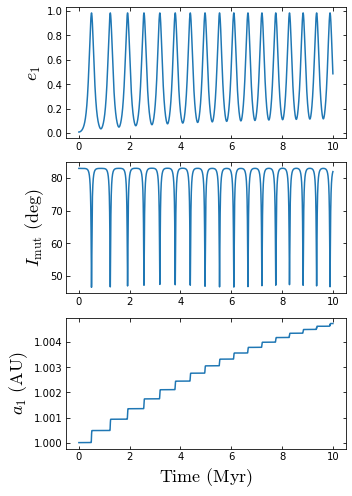

In [9]:
rad2deg = 180./np.pi
scale = 1e6
plt.figure(1,figsize=(5,7))
plt.subplot(3,1,1)
plt.plot(df.t/scale,df.e1)
plt.ylabel(r"$e_1$",fontsize=18)

plt.subplot(3,1,2)
plt.plot(df.t/scale,df.Imut*rad2deg)
plt.ylabel(r"$I_{\mathrm{mut}}$ $(\mathrm{deg})$",fontsize=18)

plt.subplot(3,1,3)
plt.plot(df.t/scale,df.a1)
plt.xlabel(r"$\mathrm{Time}$ $(\mathrm{Myr})$",fontsize=18)
plt.ylabel(r"$a_1$ $(\mathrm{AU})$",fontsize=18)
plt.tight_layout()

The figures above show the eccentricity of the planet's orbit around its star (top panel), the inclination of the planet's orbit relative to the binary star orbit (middle panel), and the semi-major axis of the planet (bottom panel). The eccentricity and inclination of the planet oscillate due to the torque exerted on the planet by the distant star. The semi-major axis undergoes a small change at each eccentricity maximum due to the tides, but we did not integrate the ODEs for long enough for tides to have a significant impact on the semi-major axis. Now let's try running the ODE solver for 500 million years (this will take a few minutes to run):

In [10]:
tend = 5e8
Npoints = 100000
t = np.linspace(0, tend, Npoints)

# Integrate the ODEs
t, sol, flag, sflag, qflag = io.integrate_triple(
    parameters,
    t,
    evolve_spin2_axis=False,
    diss_tide2=True,
    mbraking1=True,
    min_peri=min_peri,
    min_a=min_a,
    min_e=min_e,
)

# Process the output of the ODEs
df = io.process_output(t, sol, parameters, evolve_spin2_axis=False)

Setting up simulation # 0
GR apsidal precession:  True
Tidal apsidal precession due to primary:  True
Tidal apsidal precession due to secondary:  True
Spin apsidal precession due to primary:  True
Spin apsidal precession due to secondary:  True
Spin nodal precession due to primary:  True
Spin nodal precession due to secondary:  True
Evolve spin axis of secondary:  False
Tidal dissipation in primary:  False
Tidal dissipation in secondary:  True
Magnetic braking in primary:  True
Magnetic braking in secondary:  False
Octupole:  True
Minimum pericenter:  0.007663600582638584
Minimum a and e:  0.1 0.5
Exited the first integration loop. t/tmax, a, e, peri, eps_gr =  0.61 0.07 0.79 0.01 30.05
Migrating body is de-coupled from tertiary. Ignoring e-precession and tertiary
Finished the integration. Quality flag:  True
Outcome:  HJ 1


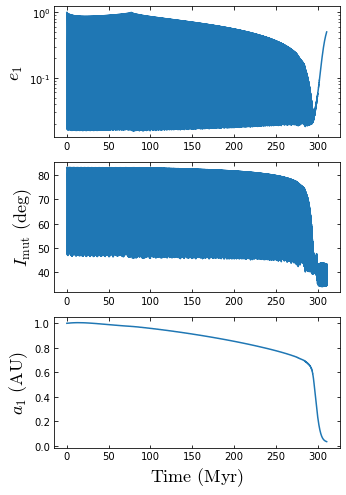

In [11]:
scale = 1e6
plt.figure(1,figsize=(5,7))
plt.subplot(3,1,1)
plt.semilogy(df.t/scale,1 - df.e1)
plt.ylabel(r"$e_1$",fontsize=18)

plt.subplot(3,1,2)
plt.plot(df.t/scale,df.Imut*rad2deg)
plt.ylabel(r"$I_{\mathrm{mut}}$ $(\mathrm{deg})$",fontsize=18)

plt.subplot(3,1,3)
plt.plot(df.t/scale,df.a1)
plt.xlabel(r"$\mathrm{Time}$ $(\mathrm{Myr})$",fontsize=18)
plt.ylabel(r"$a_1$ $(\mathrm{AU})$",fontsize=18)
plt.tight_layout()

Over this longer timescale, the eccentricity and inclination of the planetary orbit underwent many oscillations, and the planet gradually migrated inward due to tidal dissipation, eventually becoming a hot Jupiter (with semi-major axis < 0.1 AU). The outcome `HJ` (`1`) here means that the planet migrated inward, resulting in a semi-major axis < `min_a` (which we set to 0.1 AU in this example). 

The dataframe returned by `process_output` contains many other quantities of interest. Below we plot the stellar obliquity (angle between the spin axis of the star and the orbital axis of the planet), which evolves chaotically before finally settling to a retrograde (> 90 degrees) value. Indeed, many hot Jupiters are observed to be on severely misaligned orbits relative to their stars, which yields clues about their formation histories.

Text(0, 0.5, '$\\mathrm{Obliquity}$ $(\\mathrm{deg})$')

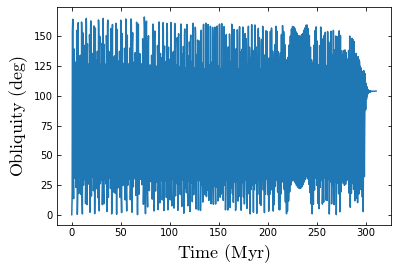

In [12]:
plt.figure(2)
plt.plot(df.t/scale,df.theta1*rad2deg)
plt.xlabel(r"$\mathrm{Time}$ $(\mathrm{Myr})$",fontsize=18)
plt.ylabel(r"$\mathrm{Obliquity}$ $(\mathrm{deg})$",fontsize=18)

The `run_in_batch` directory provides scripts for running a large number of simulations in parallel to efficiently explore the parameter space.